In [1]:
import torch
import numpy as np 
import pandas as pd
import os, json, cv2, random, time, datetime
import matplotlib.pyplot as plt
from collections import OrderedDict
from IPython.display import display, HTML

DIR_EXPS = './experiments' # Path of folder containing outputs of each experiment
experiment = 'exp6' #@@@ OVERRIDE: choose one experiment to vsualize metrics

In [2]:
def plot_metrics_training(tr_df, columns:list, title:str):
    mask = tr_df.loc[:, columns].dropna()
    mask.index = [int(tr_df.iloc[i, tr_df.columns.get_loc('iteration')]+1) for i in mask.index]
    ax = mask.plot(figsize=(10,6))
    ax.set_title(title)
    ax.set_xlabel('Iteration number');

def show_AP_categories(df, task):
    main = df.loc[:, [c for c in df.columns if c.split('/')[-1] in ['AP', 'AP50', 'AP75', 'APl', 'APm', 'APs'] and c.startswith(task)]]
    tsk = df.loc[:, [c for c in df.columns if c.startswith(task+'/AP-')]].dropna(how='all').T.round(decimals=2)
    display(main.T.round(decimals=2))
    display(tsk.style.applymap(lambda x: 'color: red' if pd.isnull(x) or x == 0 else ''))

def plot_AP_categories(df, task:str):
    dff = df.T
    # plot bbox or segm
    plt.figure(figsize=(15, 5))
    plt.title('{} AP by category'.format(task.upper()), fontsize=10, fontweight='bold')
    plt.ylabel('AP (%)')
    plt.xlabel('Iteration number')
    plt.legend( loc=9)
    legends = []
    for c in dff.columns:
        legends.append(c.split('-')[-1])
        plt.plot(dff.index, dff.loc[:, c].tolist(), lw=0.9)
    plt.legend(labels=legends, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=10);

In [15]:
# Visualize Training/Validation metrics 
out_dir = os.path.join(DIR_EXPS, experiment)
metrics = [json.loads(line) for line in open(os.path.join(out_dir, 'metrics.json'), 'r')]
df = pd.DataFrame(metrics)

# Validation metrics
val = df.loc[:, ['validation_loss']+[c for c in df.columns if 'AP' in c]].dropna(axis=0, how='all').round(decimals=2)
val.index = [int(df.iloc[i, df.columns.get_loc('iteration')]+1)for i in val.index]

val_main = val.loc[:, ['validation_loss']+[c for c in df.columns if c.split('/')[-1] in ['AP', 'AP50', 'AP75', 'APl', 'APm', 'APs']]]

val_cats_segm = val.loc[:, [c for c in val.columns if c.startswith('segm/AP-')]].dropna(how='all').T
val_cats_bbox = val.loc[:, [c for c in val.columns if c.startswith('segm/AP-')]].dropna(how='all').T

# Training metrics 
tr = df.loc[:, [c for c in df.columns if 'AP' not in c]].iloc[:-1, :]
tr.rename({'total_loss': 'train_loss'}, axis=1, inplace=True)


    Last Iteration:
    Total Loss: 0.17454106971854344
    Validation Loss: 0.37937524664799127
    


,250,500,750,1000,1250,1500,1750,2000,2250,2500,...,3000,3250,3500,3750,4000,4250,4500,4750,5000,5001
segm/AP,22.57,29.12,31.95,35.15,37.40,43.41,47.54,47.11,47.80,47.88,...,48.59,47.94,47.95,48.38,48.80,47.82,47.95,47.96,NaN,47.94
segm/AP50,31.01,38.72,42.28,45.99,49.48,55.25,59.99,59.19,59.60,60.01,...,60.73,60.05,59.98,60.56,61.06,59.86,60.02,59.95,NaN,59.89
segm/AP75,25.65,33.30,36.40,40.28,42.34,49.57,54.64,54.00,54.70,54.85,...,55.49,54.90,54.79,55.14,55.65,54.86,54.77,54.76,NaN,54.63
segm/APl,25.51,32.23,35.75,40.01,42.44,47.64,51.58,50.81,50.60,51.26,...,52.01,51.25,51.35,51.45,51.81,50.94,50.82,50.86,NaN,50.88
segm/APm,26.66,31.94,35.52,37.82,36.34,44.86,43.04,43.05,42.18,39.88,...,40.00,39.77,39.87,39.78,39.97,39.96,40.06,39.85,NaN,39.87
segm/APs,26.57,28.54,25.93,28.27,31.57,32.16,29.50,29.35,30.23,28.02,...,28.24,27.97,28.25,28.29,28.29,28.17,28.37,28.43,NaN,28.32


,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5001
segm/AP-bag,17.430000,20.420000,21.080000,22.180000,23.560000,21.760000,24.050000,24.100000,23.700000,23.250000,23.370000,23.280000,23.680000,23.750000,23.940000,24.220000,24.030000,24.460000,24.440000,24.550000
segm/AP-bathrobe,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
segm/AP-blazer,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
segm/AP-boots,17.850000,34.860000,31.680000,29.390000,35.980000,39.990000,37.980000,36.550000,36.990000,37.090000,38.430000,37.530000,36.890000,36.830000,36.250000,37.880000,36.900000,36.640000,36.610000,36.670000
segm/AP-cardigan,9.220000,13.250000,20.940000,21.090000,35.490000,33.920000,39.130000,40.970000,41.640000,47.810000,48.670000,48.120000,45.250000,47.990000,46.530000,45.610000,45.560000,45.670000,47.170000,46.920000
segm/AP-coat,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
segm/AP-cover_ups,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
segm/AP-dress,58.740000,67.410000,67.910000,70.960000,68.740000,72.750000,74.740000,75.710000,75.870000,76.520000,77.210000,77.160000,77.160000,76.960000,77.360000,77.140000,77.440000,76.910000,76.930000,76.750000
segm/AP-flat_shoes,13.390000,10.970000,11.200000,9.430000,14.560000,19.350000,15.960000,15.390000,13.680000,14.480000,13.940000,13.580000,14.230000,14.500000,12.920000,14.030000,12.910000,13.390000,13.320000,14.000000
segm/AP-hat,33.430000,39.900000,44.900000,43.060000,44.260000,47.050000,50.320000,48.860000,50.410000,49.840000,50.030000,50.840000,50.500000,50.170000,50.100000,50.600000,48.890000,50.340000,49.100000,48.970000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


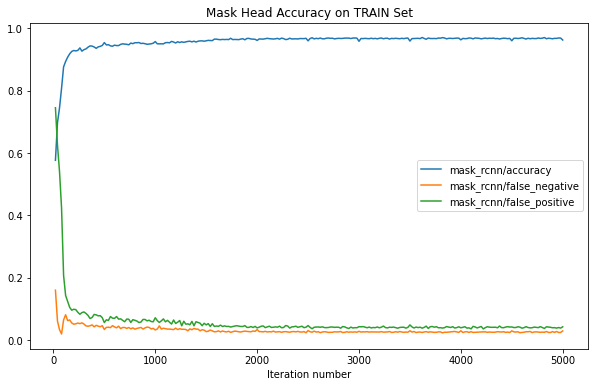

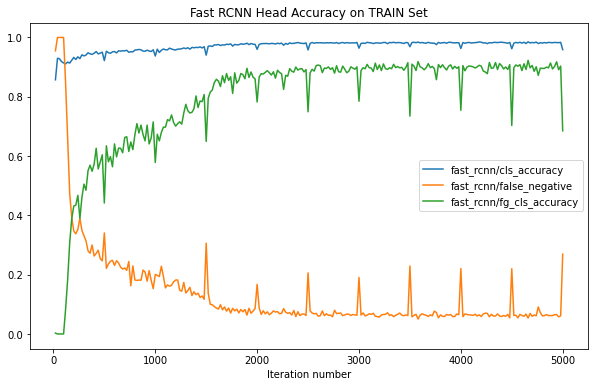

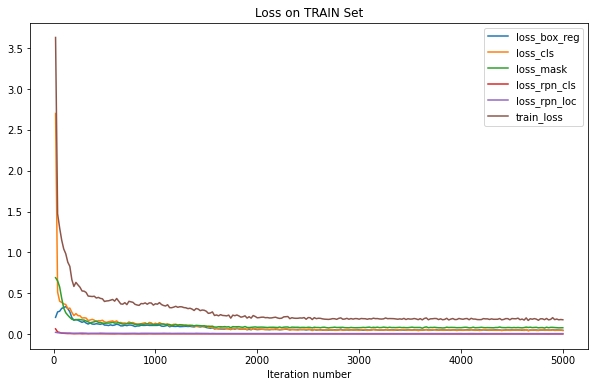

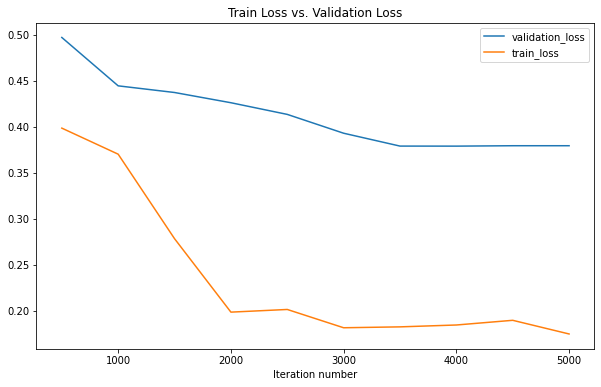

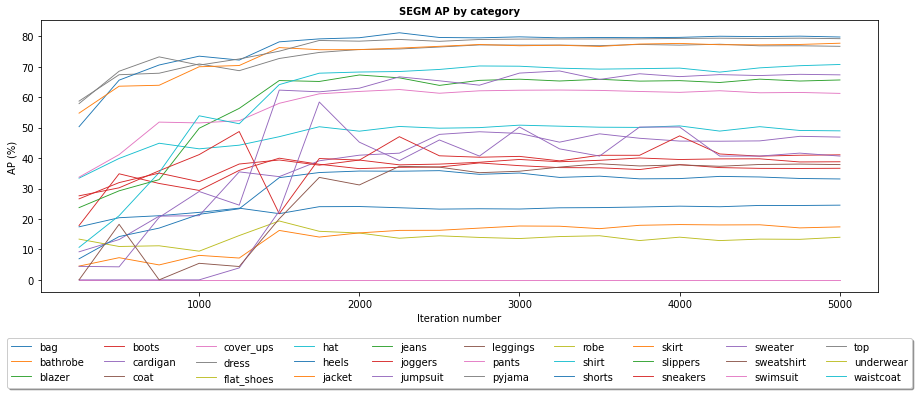

In [16]:
# Plot Mask Head Accuracy on Train Set 
plot_metrics_training(tr, [c for c in tr.columns if c.startswith('mask_rcnn')], 'Mask Head Accuracy on TRAIN Set')

# Plot Fast Rcnn (?) Accuracy on Train Set
plot_metrics_training(tr, [c for c in tr.columns if c.startswith('fast_rcnn')], 'Fast RCNN Head Accuracy on TRAIN Set')

# Plot Training Loss
plot_metrics_training(tr, [c for c in tr.columns if 'loss' in c and 'validation' not in c], 'Loss on TRAIN Set')

# Plot Training vs Validation Loss
plot_metrics_training(tr, ['validation_loss', 'train_loss'], 'Train Loss vs. Validation Loss')

print(
    """
    Last Iteration:
    Total Loss: {}
    Validation Loss: {}
    """.format(df.iloc[-2, df.columns.get_loc('total_loss')], df.iloc[-2, df.columns.get_loc('validation_loss')]))

# Track Average Precision on Val Set for mask detection (segm) or bbox detection (bbox)
show_AP_categories(val, 'segm')

# Plot evolution of Average Precision on Val Set for mask detection (segm) or bbox detection (bbox) by categories
plot_AP_categories(val_cats_segm, 'segm')